In [62]:
import numpy as np
import jax.numpy as jnp
from jax import value_and_grad,random
from jax import jit,vmap
from jax.tree_util import tree_map
from jax.nn import relu,one_hot
from jax.scipy.special import logsumexp

In [64]:
seed = 0

def init_MLP(layer_widths, parent_key, scale = 0.01):
  params = []

  keys = random.split(parent_key, num=len(layer_widths)-1)

  for n_in, n_out, key in zip(layer_widths[:-1],layer_widths[1:],keys):
    weight_key, bias_key = random.split(key)

    params.append([
        scale*random.normal(weight_key, shape=(n_out,n_in)),
        scale*random.normal(bias_key, shape=(n_out,))
    ])

  return params

key = random.PRNGKey(seed)
MLP = init_MLP([784,128,128,10], key)
tree_map(lambda x: x.shape,MLP)

[[(128, 784), (128,)], [(128, 128), (128,)], [(10, 128), (10,)]]

In [65]:
def MLP_predict(params, x):
  hidden_layers = params[:-1]

  activation = x
  for w,b in hidden_layers:
    activation = relu(jnp.dot(w,activation)+b)

  w_last, b_last = params[-1]
  logits = jnp.dot(w_last,activation)+b_last

  return logits-logsumexp(logits)

batched_MLP_predict = vmap(MLP_predict, in_axes=(None,0))

dummy_img = np.random.randn(16,np.prod((28,28)))
pred = batched_MLP_predict(MLP, dummy_img)
pred.shape

(16, 10)

## ETL

In [66]:
import os
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

In [67]:
print(os.getcwd())

/content


In [68]:
def torch2jax(x):
  x = np.array(x,dtype=np.float32)
  return np.ravel(x)

train_dataset = MNIST(root='train_mnist',train=True,download=True, transform=torch2jax)
test_dataset = MNIST(root='test_mnist',train=False,download=True,transform=torch2jax)

print(type(train_dataset))
something = train_dataset[0]
print(type(something[0]),type(something[1]))

<class 'torchvision.datasets.mnist.MNIST'>
<class 'numpy.ndarray'> <class 'int'>


In [80]:
def collate_tensor(batch):
  transposed_data = list(zip(*batch))

  labels = np.array(transposed_data[1])
  imgs = np.stack(transposed_data[0])

  return imgs,labels

batch_size = 128

train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,collate_fn=collate_tensor,drop_last = True)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False,collate_fn=collate_tensor,drop_last=True)

In [81]:
batch_data = next(iter(train_loader))
print(type(batch_data[0]))

<class 'numpy.ndarray'>


In [82]:
imgs = batch_data[0]
labels = batch_data[1]

In [86]:
train_img = jnp.array(train_dataset.data).reshape(len(train_dataset),-1)
train_labels = jnp.array(train_dataset.targets)

test_img = jnp.array(test_dataset.data).reshape(len(test_dataset),-1)
test_labels = jnp.array(test_dataset.targets)

## Training

In [90]:
num_epochs = 10

def loss_fn(params,imgs,labels):
  pred = batched_MLP_predict(params,imgs)
  return -jnp.mean(labels*pred)

@jit
def update(params, imgs, labels,lr=0.01):
  loss,grads = value_and_grad(loss_fn)(params,imgs,labels)
  return loss,tree_map(lambda p,g: p-lr*g, params, grads)

def accuracy(params, dataset_images, dataset_labels):
  pred = batched_MLP_predict(params,dataset_images)
  return jnp.mean(jnp.argmax(pred,axis=1)==dataset_labels)

MLP = init_MLP([784,128,128,10], key)
for epoch in range(num_epochs):
  print(f"Epoch {epoch} train_acc = {accuracy(MLP,train_img,train_labels)} test_acc = {accuracy(MLP,test_img,test_labels)}")
  for cnt,(imgs,labels) in enumerate(train_loader):
    gt_labels = one_hot(labels,len(MNIST.classes))
    loss,MLP = update(MLP, imgs, gt_labels)

    if cnt % 100 == 0:
      print(f"Epoch {epoch} batch {cnt} loss = {loss}")

  print(f"Epoch {epoch} train_acc = {accuracy(MLP,train_img,train_labels)} test_acc = {accuracy(MLP,test_img,test_labels)}")

Epoch 0 train_acc = 0.08196666836738586 test_acc = 0.07490000128746033
Epoch 0 batch 0 loss = 0.23143337666988373
Epoch 0 batch 100 loss = 0.11790714412927628
Epoch 0 batch 200 loss = 0.05963176488876343
Epoch 0 batch 300 loss = 0.05189123749732971
Epoch 0 batch 400 loss = 0.04215918481349945
Epoch 0 train_acc = 0.8927333354949951 test_acc = 0.8973000049591064
Epoch 1 train_acc = 0.8927333354949951 test_acc = 0.8973000049591064
Epoch 1 batch 0 loss = 0.029500892385840416
Epoch 1 batch 100 loss = 0.026191268116235733
Epoch 1 batch 200 loss = 0.034240324050188065
Epoch 1 batch 300 loss = 0.021444501355290413
Epoch 1 batch 400 loss = 0.022068645805120468
Epoch 1 train_acc = 0.9136999845504761 test_acc = 0.9185999631881714
Epoch 2 train_acc = 0.9136999845504761 test_acc = 0.9185999631881714
Epoch 2 batch 0 loss = 0.016713378950953484
Epoch 2 batch 100 loss = 0.020525917410850525
Epoch 2 batch 200 loss = 0.018545804545283318
Epoch 2 batch 300 loss = 0.03267631307244301
Epoch 2 batch 400 los

## Visualization

7


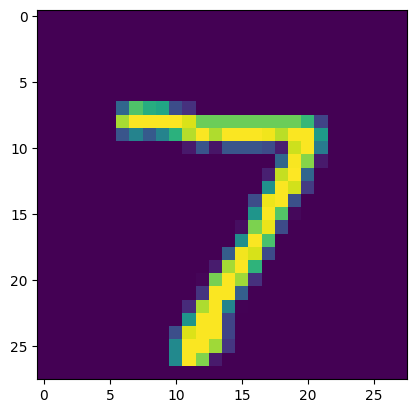

In [93]:
imgs,labels = next(iter(test_loader))
img = imgs[0].reshape(28,28)
gt_label = labels[0]

import matplotlib.pyplot as plt
print(gt_label)
plt.imshow(img)

In [98]:
pred = jnp.argmax(MLP_predict(MLP,np.ravel(img)))
pred

Array(7, dtype=int32)